#### Train a Multilayer Perceptron model with ApacheJIT dataset.

#### Import libraries.

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import SGD
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer


#### Load dataset.

In [2]:

df = None

dtypes = {"commit_id": "str", "project" : "str", "buggy" : "str", "fix" : "str", "year" : "str", "author_date" : "str",
          "la" : "int16", "ld" : "int16", "nf" : "int16", "nd" : "int16", "ns" : "int16", "ent" : "float64",
          "ndev" : "float64", "age" : "float64", "nuc" : "float64", "aexp" : "int16", "arexp" : "float64", "asexp" : "float64"}

try:
    print("\nStart loading CSV file...")
    df = pd.read_csv("../dataset/java/apachejit_total.csv", sep = ",", dtype = dtypes)
    print("\nFinish loading CSV file...")
except Exception as e:
    print("\nFail to load CSV file.")
    print("Error: {}".format(e))



Start loading CSV file...

Finish loading CSV file...


#### Check for dataset shape.

In [3]:

df.shape


(106674, 18)

#### Remove unnecessary features from the dataset and show class identification.

In [4]:

df.drop(columns = ["commit_id", "project", "fix", "year", "author_date"], inplace = True)
le = LabelEncoder()
df.loc[:, ["buggy"]] = le.fit_transform(df["buggy"])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Dataset classes: {mapping}")


Dataset classes: {'False': np.int64(0), 'True': np.int64(1)}


#### Create a helper function to train a Multilayer Perceptron model.

In [5]:

def apply_upsampling(X_array, y_array):
    # Apply SMOTE to balance the dataset.
    # Parameters:
    #    X_array (np.array): array of features values.
    #    y_array (np.array): array of target values.
    # Return:
    #    X_array (np.array): array of features values.
    #    y_array (np.array): array of target values.
    print("\nGenerating upsampling using SMOTE...")
    smote = SMOTE(sampling_strategy = "auto", k_neighbors = 5, random_state = 42)
    X_array_res, y_array_res = smote.fit_resample(X_array, y_array)
    print("{} samples after SMOTE.".format(len(y_array_res)))
    print("Finish generating SMOTE.")
    print(f"Class distribution for training after SMOTE: {Counter(y_array_res)}")
    return X_array_res, y_array_res

def train_mlp_model(mlp_model, X, y, num_epochs, batch_size, model_cfg_file):
    # Train a MLP model.
    # Parameters:
    #    mlp_model (Sequential): model to be trained.
    #    X (np.array): array of features values.
    #    y (np.array): array of target values.
    #    num_epochs (int): number of epochs of training.
    #    batch_size (int): batch size.
    #    model_cfg_file (str): file to save the configuration model.
    # Returns:
    #    history (History object): history of training metrics.
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    start_time = time.time()
    X_train = X
    y_train = y
    es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30, restore_best_weights = True)
    train_accuracy_by_fold = []
    test_accuracy_by_fold = []
    fold_number = 1
    history_by_fold = []
    y_predclass_for_report = []
    y_testclass_for_report = []
    print("\nStarting training...")
    rb_scaler = PowerTransformer()
    for train_index, test_index in skf.split(X_train, y_train):
        print("\nTraining fold {}".format(fold_number))
        X_train_fold, y_train_fold = apply_upsampling(X_train[train_index], y_train[train_index])
        X_train_fold = rb_scaler.fit_transform(X_train_fold)
        history = mlp_model.fit(X_train_fold, y_train_fold, validation_split = 0.01,
                                epochs = num_epochs, batch_size = batch_size, 
                                verbose = 1, callbacks = [es])
        _, train_accuracy = mlp_model.evaluate(X_train_fold, y_train_fold, verbose = 0)
        X_test_fold = rb_scaler.transform(X_train[test_index])
        y_test_fold = y_train[test_index].ravel()
        _, test_accuracy = mlp_model.evaluate(X_test_fold, y_test_fold, verbose = 0)
        train_accuracy_by_fold.append(train_accuracy)
        test_accuracy_by_fold.append(test_accuracy)
        y_predclass_for_report.extend(np.argmax(mlp_model.predict(X_test_fold), axis = 1))
        y_testclass_for_report.extend(y_test_fold)
        history_by_fold.append(history)
        fold_number += 1
    mlp_model.save("../modelconfig/" + model_cfg_file)
    elapsed_seconds = int(time.time() - start_time)
    formatted_time = "{:02d}d {:02d}:{:02d}:{:02d}".format(
        elapsed_seconds // 86400,  # Days
        (elapsed_seconds % 86400) // 3600,  # Hours
        (elapsed_seconds % 3600) // 60,  # Minutes
        elapsed_seconds % 60  # Seconds
    )
    print("\nTime taken for training: ", formatted_time)
    print("\n")
    # Show metrics.
    for i in range(len(train_accuracy_by_fold)):
        print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1), train_accuracy_by_fold[i],
                                                                              test_accuracy_by_fold[i]))
    print("\nMean Train Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(train_accuracy_by_fold),
                                                                np.std(train_accuracy_by_fold)))
    print("Mean Test Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(test_accuracy_by_fold),
                                                             np.std(test_accuracy_by_fold)))
    print("\nEvaluate other metrics:")
    print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))
    ConfusionMatrixDisplay.from_predictions(y_testclass_for_report, y_predclass_for_report)
    return history_by_fold


#### Create helper functions to instantiate Multilayer Perceptron models.

In [30]:

act_fuction = "relu"
k_init = "he_normal"

def create_baseline():
    model = Sequential()
    model.add(Input(shape=(12,)))
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2, activation = "softmax"))
    opt = SGD(learning_rate = 0.001, momentum = 0.9, nesterov = True)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model

def create_v2():
    model = Sequential()
    model.add(Input(shape=(12,)))
    model.add(Dense(512, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2048, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(512, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2, activation = 'softmax'))
    opt = SGD(learning_rate = 0.001, momentum = 0.9, nesterov = True)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model


#### Separate features.

In [6]:

feature_names = ["la", "ld", "nf", "nd", "ns", "ent", "ndev", "age", "nuc", "aexp", "arexp", "asexp"]

X = df.loc[:, feature_names].values
y = df.loc[:, ["buggy"]].values.astype(int)


#### Train baseline version of Multilayer Perceptron.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,282 (36.26 KB)

 Trainable params: 9,282 (36.26 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
125496 samples after SMOTE.
Finish generating SMOTE.
Class distribution for training after SMOTE: Counter({np.int64(0): 62748, np.int64(1): 62748})
Epoch 1/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7159 - loss: 0.5552 - val_accuracy: 0.7052 - val_loss: 0.5656
Epoch 2/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7470 - loss: 0.5119 - val_accuracy: 0.8104 - val_loss: 0.4526
Epoch 3/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7511 - loss: 0.5069 - val_accuracy: 0.7713 - val_loss: 0.4876
Epoch 4/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7569 - loss: 0.4989 - val_accuracy: 0.8351 - val_loss: 0.3845
Epoch 5/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7575 - loss: 0.4972 - val_accuracy: 0.7785 - val_loss: 0.4682
Epoch 6/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7611 - loss: 0.4922 - val_accuracy: 0.8104 - val_l

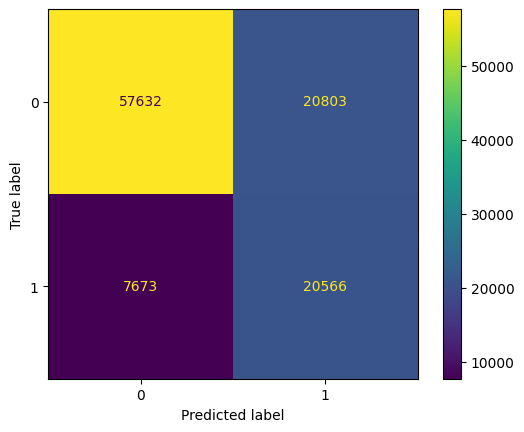

In [8]:

bs_model = create_baseline()
bs_num_epochs = 500
bs_batch_size = 32

training_history = train_mlp_model(bs_model, X, y, bs_num_epochs, bs_batch_size, "baseline_model.keras")


#### Train version 2 of Multilayer Perceptron.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,107,394 (8.04 MB)

 Trainable params: 2,107,394 (8.04 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
125496 samples after SMOTE.
Finish generating SMOTE.
Class distribution for training after SMOTE: Counter({np.int64(0): 62748, np.int64(1): 62748})
Epoch 1/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.7281 - loss: 0.5479 - val_accuracy: 0.7331 - val_loss: 0.5261
Epoch 2/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7528 - loss: 0.5002 - val_accuracy: 0.7131 - val_loss: 0.5544
Epoch 3/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.7605 - loss: 0.4927 - val_accuracy: 0.7960 - val_loss: 0.4482
Epoch 4/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.7663 - loss: 0.4812 - val_accuracy: 0.7936 - val_loss: 0.4334
Epoch 5/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.7686 - loss: 0.4773 - val_accuracy: 0.8606 - val_loss: 0.3669
Epoch 6/500
3883/3883 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.7744 - loss: 0.4702 - val_accuracy: 0.7912 - 

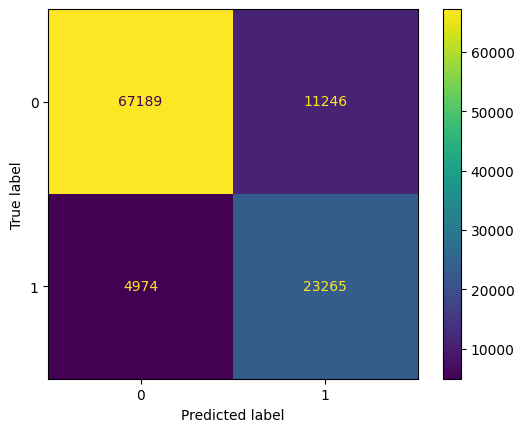

In [8]:

v2_model = create_v2()
v2_num_epochs = 500
v2_batch_size = 32

training_history_v2 = train_mlp_model(v2_model, X, y, v2_num_epochs, v2_batch_size, "v2_model.keras")


#### Show training accuracy history.

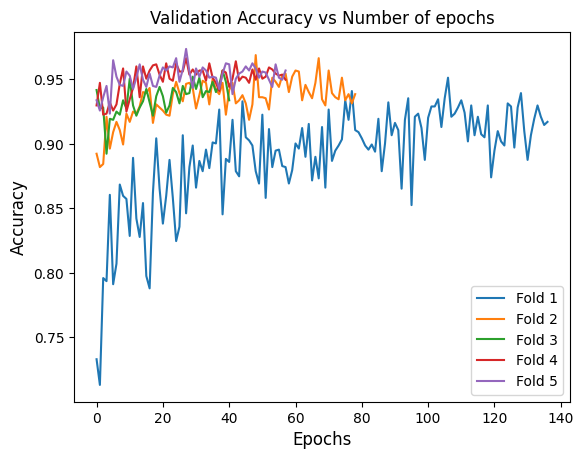

In [9]:

# Plot accuracy history
for i in range(len(training_history_v2)):
    plt.plot(training_history_v2[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()


#### Show training loss history.

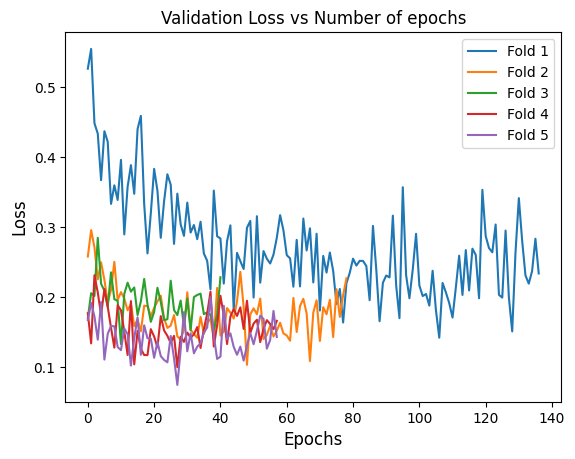

In [10]:

# Plot loss history
for i in range(len(training_history_v2)):
    plt.plot(training_history_v2[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()
